In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 10
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((517, 12, 1), (517,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT10/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 38s 500ms/step - loss: 0.1932 - root_mean_squared_error: 0.4395 - val_loss: 0.0990 - val_root_mean_squared_error: 0.3146
Epoch 2/50
53/53 [==============================] - 25s 474ms/step - loss: 0.0575 - root_mean_squared_error: 0.2399 - val_loss: 0.0537 - val_root_mean_squared_error: 0.2317
Epoch 3/50
53/53 [==============================] - 26s 491ms/step - loss: 0.0417 - root_mean_squared_error: 0.2042 - val_loss: 0.0412 - val_root_mean_squared_error: 0.2030
Epoch 4/50
53/53 [==============================] - 25s 488ms/step - loss: 0.0331 - root_mean_squared_error: 0.1819 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1694
Epoch 5/50
53/53 [==============================] - 25s 479ms/step - loss: 0.0216 - root_mean_squared_error: 0.1469 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1473
Epoch 6/50
53/53 [==============================] - 26s 495ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0206 

53/53 [==============================] - 3s 60ms/step - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 34/50
53/53 [==============================] - 26s 498ms/step - loss: 0.0090 - root_mean_squared_error: 0.0950 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 35/50
53/53 [==============================] - 4s 67ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1168
Epoch 36/50
53/53 [==============================] - 4s 74ms/step - loss: 0.0088 - root_mean_squared_error: 0.0939 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1077
Epoch 37/50
53/53 [==============================] - 27s 510ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 38/50
53/53 [==============================] - 4s 76ms/step - loss: 0.0090 - root_mean_squared_error: 0.0948 - val_loss: 0.0131 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

10.879642736911773 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

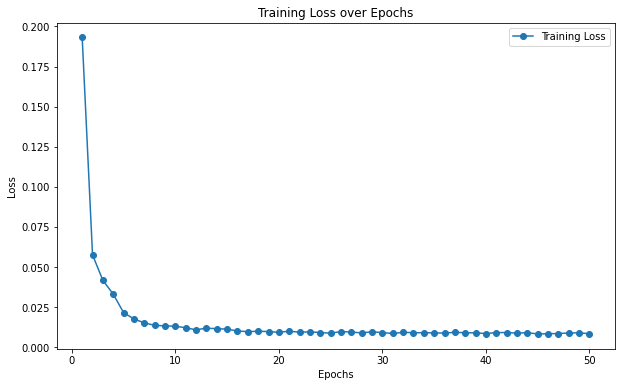

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

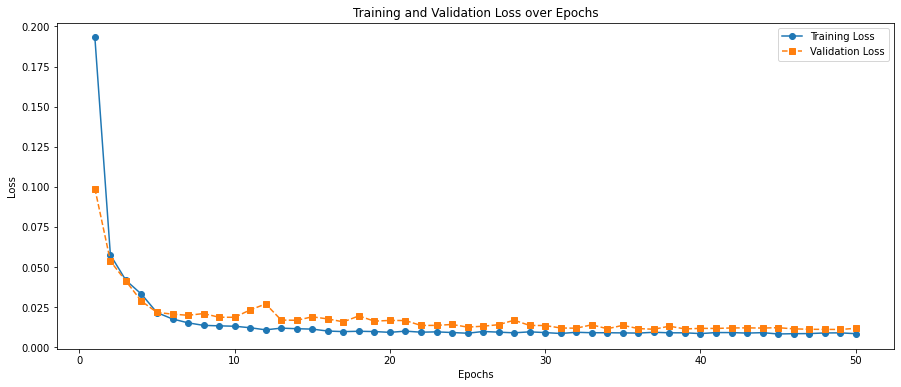

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT10/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 32ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0945210271926904
MAE : 0.08008146676668665


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,3.866982e+05,451914.219
1,3.071840e+05,439855.813
2,5.338711e+05,807857.307
3,9.405974e+05,1184280.145
4,1.457257e+06,1468308.405
5,1.790405e+06,1540851.607
6,2.007831e+06,1989099.836
7,2.085438e+06,2096990.761
8,1.932742e+06,2080961.032
9,1.604995e+06,1695704.661


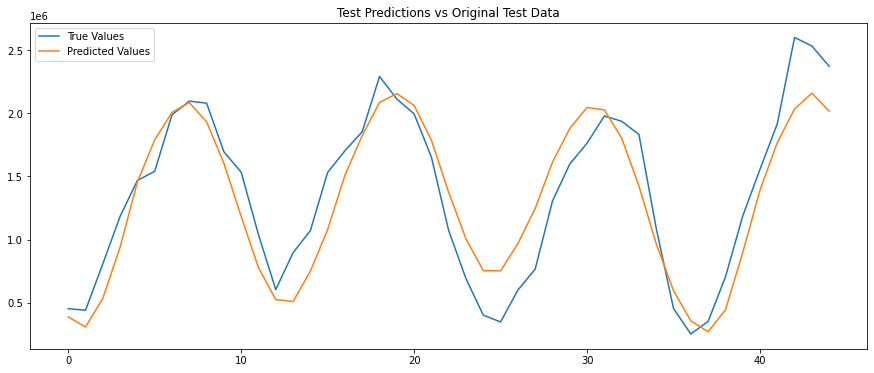

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 25ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

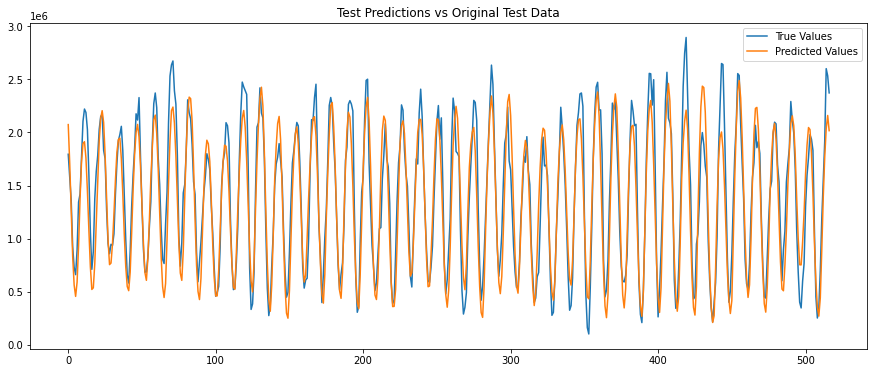

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()